<a href="https://colab.research.google.com/github/AryanShr/offenSec/blob/main/AdversarialFeatureVectureGenerator/GAN_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Output/Original.pk','rb') as f:
  orig = pickle.load(f)

orig[0]

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
with open('/content/drive/MyDrive/Output/diff_adversarial_feature_set.pk','rb') as f:
  data_diff = pickle.load(f)

data_diff[0]

tensor([[1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.]])

In [ ]:
with open('/content/drive/MyDrive/Output/adversarial_feature_set.pk','rb') as f:
  data = pickle.load(f)

data[0]

tensor([[1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [ ]:
import torch
import torch.nn.functional as F

def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler Divergence
    Args:
    p (Tensor): Tensor representing distribution p
    q (Tensor): Tensor representing distribution q
    Returns:
    float: The KL divergence between p and q
    """
    p = F.softmax(p, dim=0)
    q = F.softmax(q, dim=0)
    return torch.sum(p * torch.log(p / q), dim=0)

In [ ]:
def js_divergence(p, q):
    """
    Compute the Jensen-Shannon Divergence
    Args:
    p (Tensor): Tensor representing distribution p
    q (Tensor): Tensor representing distribution q
    Returns:
    float: The JS divergence between p and q
    """
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


In [ ]:
num_bins = 10


In [ ]:
histograms1 = [torch.histc(t.flatten(), bins=num_bins, min=0, max=1) for t in data]

In [ ]:
histograms2 = [torch.histc(t.flatten(), bins=num_bins, min=0, max=1) for t in data_diff]

In [ ]:
histograms3 = [torch.histc(t.flatten(), bins=num_bins, min=0, max=1) for t in orig]

In [ ]:
prob_distributions1 = [h / h.sum() for h in histograms1]
prob_distributions2 = [h / h.sum() for h in histograms2]
prob_distributions3 = [h / h.sum() for h in histograms3]

In [ ]:
total_kl_div1 = 0
total_js_div1 = 0
total_kl_div2 = 0
total_js_div2 = 0

In [ ]:
for i in range(len(data)):
    for j in range(i+1, len(data)):
        total_kl_div1 += kl_divergence(prob_distributions1[i], prob_distributions3[j])
        total_js_div1 += js_divergence(prob_distributions1[i], prob_distributions3[j])

In [ ]:
for i in range(len(data_diff)):
    for j in range(i+1, len(data_diff)):
        total_kl_div2 += kl_divergence(prob_distributions2[i], prob_distributions3[j])
        total_js_div2 += js_divergence(prob_distributions2[i], prob_distributions3[j])

In [ ]:
avg_kl_div1 = total_kl_div1 / (len(data) * (len(orig) - 1) / 2)
avg_js_div1 = total_js_div1 / (len(data) * (len(orig) - 1) / 2)
avg_kl_div2 = total_kl_div2 / (len(data_diff) * (len(orig) - 1) / 2)
avg_js_div2 = total_js_div2 / (len(data_diff) * (len(orig) - 1) / 2)

In [ ]:
avg_kl_div1, avg_js_div1

(tensor(0.0287), tensor(0.0072))

In [ ]:
avg_kl_div2, avg_js_div2

(tensor(0.0396), tensor(0.0099))

In [ ]:
def euclidean_distance(tensor1, tensor2):
    return torch.sqrt(torch.sum((tensor1 - tensor2) ** 2))


In [ ]:
def pad_tensor(t, target_length):
    """
    Pad tensor 't' with zeros until it reaches 'target_length'.
    Args:
    t (Tensor): Tensor to be padded
    target_length (int): Desired length of the tensor after padding
    Returns:
    Tensor: The padded tensor
    """
    padding_size = target_length - t.numel()
    if padding_size > 0:
        t = torch.cat((t, torch.zeros(padding_size)), dim=0)
    return t


In [ ]:
distances = []
for i in range(len(data)):
    for j in range(i + 1, len(orig)):
        max_length = max(data[i].numel(), orig[j].numel())
        distance = euclidean_distance(pad_tensor(data[i].flatten(), max_length), pad_tensor(orig[j].flatten(), max_length))
        distances.append(distance.item())


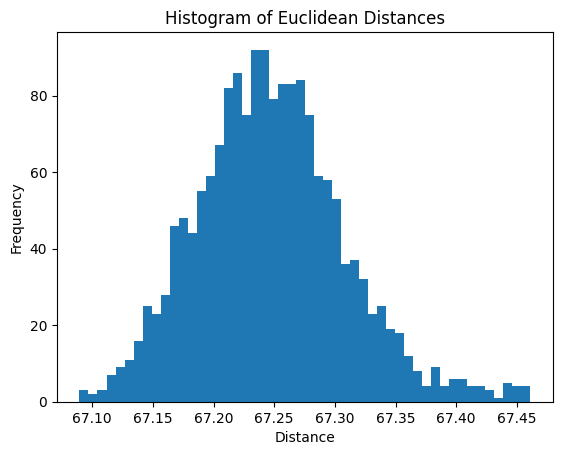

In [ ]:
import matplotlib.pyplot as plt

plt.hist(distances, bins=50)
plt.title('Histogram of Euclidean Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


In [ ]:
distances_diff = []
for i in range(len(data_diff)):
    for j in range(i + 1, len(orig)):
        max_length = max(data_diff[i].numel(), orig[j].numel())
        distance = euclidean_distance(pad_tensor(data_diff[i].flatten(), max_length), pad_tensor(orig[j].flatten(), max_length))
        distances_diff.append(distance.item())


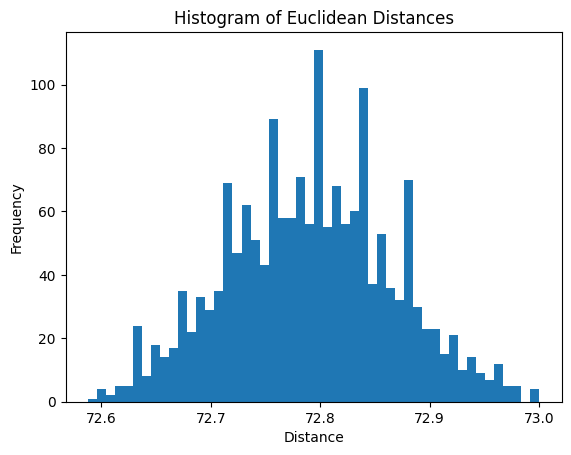

In [ ]:
import matplotlib.pyplot as plt

plt.hist(distances_diff, bins=50)
plt.title('Histogram of Euclidean Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()
